# Using Spark ML Pipeline Predicting Score
This notebook builds a Logistic Regression Model based on Spark pipeline to predict the score of Reddit Posts of Personal Finance Subreddit. 

## Import and Pre-Processed Data

In [1]:
sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1622769166794_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version   
-------------------------- ----------
awscli                     1.19.87   
beautifulsoup4             4.9.3     
boto                       2.49.0    
botocore                   1.20.87   
click                      7.1.2     
colorama                   0.4.3     
docutils                   0.15.2    
jmespath                   0.10.0    
joblib                     0.17.0    
lxml                       4.6.1     
mysqlclient                1.4.2     
nltk                       3.5       
nose                       1.3.4     
numpy                      1.16.5    
pip                        9.0.1     
py-dateutil                2.2       
pyasn1                     0.4.8     
python-dateutil            2.8.1     
python37-sagemaker-pyspark 1.4.1     
pytz                       2020.1    
PyYAML                     5.3.1     
regex                      2020.10.28
rsa                        4.7.2     
s3transfer                 0.4.2     
setuptools  

In [2]:
sc.install_pypi_package("boto3") # use boto3 to see book data in S3 bucket
sc.install_pypi_package("seaborn")
sc.install_pypi_package("pandas")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/0e/02/d0e07f3782cc054269ae0649ab1e3a0205fee1168545d4e502e62c27ba7e/boto3-1.17.87-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/68/ad/6c2406ae175f59ec616714e408979b674fe27b9587f79d59a528ddfbcd5b/seaborn-0.11.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7d/e8/43ffca541d2f208d516296950b25fe1084b35c2881f4d444c1346ca75815/scipy-1.6.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/24/33/5568d443ba438d95d4db635dd69958056f087e57e1026bee56f959d53f9d/matplotlib-3.4.2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/51/51/48f3fc47c4e2144da2806dfb6629c4dd1fa3d5a143f9652b141e979a8ca9/pandas-1.2.4-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https:/

In [53]:
import boto3
import numpy as np

from pyspark.ml.classification import LogisticRegression
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
import pyspark.ml.evaluation as evals

import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
data = spark.read.csv('s3://large-scale-computing-personal-finance/raw-data/personalfinance_2020-01-01_2021-01-01.csv', 
                      header=True, 
                      sep=',', 
                      escape="\"", 
                      multiLine=True,
                      inferSchema=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- all_awardings: string (nullable = true)
 |-- allow_live_comments: string (nullable = true)
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_richtext: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_flair_type: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- author_patreon_flair: string (nullable = true)
 |-- author_premium: string (nullable = true)
 |-- awarders: string (nullable = true)
 |-- can_mod_post: string (nullable = true)
 |-- contest_mode: string (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- full_link: string (nullable = true)
 |-- gildings: string (nullable = true)
 |-- id: string (nullable = true)
 |-- is_crosspostable: string (nullable = true)
 |-- is_meta: string (nullable = true)
 |-- is_original_content: string (nullable = true)
 |-- is_reddit_media_domain: string (nullable = t

Variables:

- link_flair_css_class
- num_comments
- length of selftext
- length of title

In [22]:
data = (data[['title', 'selftext', 'link_flair_css_class','num_comments','score']]
        .filter("selftext != '[removed]' and link_flair_css_class != 'Unset'")
        .dropna())
data.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+------------+-----+
|               title|            selftext|link_flair_css_class|num_comments|score|
+--------------------+--------------------+--------------------+------------+-----+
|Trade in car or k...|So we have a Jeep...|                Auto|           5|    1|
|About to purchase...|I am about to pur...|             Housing|           9|    1|
|How much should m...|I'm currently liv...|             Housing|          50|    1|
|21 yrs old, 721 c...|I don’t know anyt...|              Credit|           5|    1|
|Medical Bill issu...|Basically a month...|                Debt|           7|    1|
+--------------------+--------------------+--------------------+------------+-----+
only showing top 5 rows

In [13]:
data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- title: string (nullable = true)
 |-- selftext: string (nullable = true)
 |-- link_flair_css_class: string (nullable = true)
 |-- num_comments: integer (nullable = true)
 |-- score: integer (nullable = true)

In [23]:
data = data.withColumn('high_score', (data.score >= 2).cast("integer"))
data.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+------------+-----+----------+
|               title|            selftext|link_flair_css_class|num_comments|score|high_score|
+--------------------+--------------------+--------------------+------------+-----+----------+
|Trade in car or k...|So we have a Jeep...|                Auto|           5|    1|         0|
|About to purchase...|I am about to pur...|             Housing|           9|    1|         0|
|How much should m...|I'm currently liv...|             Housing|          50|    1|         0|
|21 yrs old, 721 c...|I don’t know anyt...|              Credit|           5|    1|         0|
|Medical Bill issu...|Basically a month...|                Debt|           7|    1|         0|
+--------------------+--------------------+--------------------+------------+-----+----------+
only showing top 5 rows

In [24]:
# count the number of high and low score
(data.groupBy('high_score')
     .count()
     .show()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------+
|high_score| count|
+----------+------+
|         1|  7407|
|         0|111465|
+----------+------+

In [25]:
ratio = 8126/122289
ratio

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.06644914914669349

In [26]:
sampled = data.sampleBy("high_score",fractions={1 : 1, 0 : ratio})
sampled.groupBy("high_score").count().orderBy("high_score").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+
|high_score|count|
+----------+-----+
|         0| 7534|
|         1| 7407|
+----------+-----+

In [29]:
sampled = sampled.withColumn('text_tokens',F.split('selftext', ' ')) \
                 .withColumn('text_length',F.size('text_tokens')) \
                 .withColumn('title_tokens', F.split('title', ' ')) \
                 .withColumn('title_length', F.size('title_tokens'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
sampled.show(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+------------+-----+----------+--------------------+-----------+--------------------+------------+
|               title|            selftext|link_flair_css_class|num_comments|score|high_score|         text_tokens|text_length|        title_tokens|title_length|
+--------------------+--------------------+--------------------+------------+-----+----------+--------------------+-----------+--------------------+------------+
|What are good res...|I know about Pays...|          Employment|           2|    1|         0|[I, know, about, ...|         97|[What, are, good,...|           7|
+--------------------+--------------------+--------------------+------------+-----+----------+--------------------+-----------+--------------------+------------+
only showing top 1 row

## Build ML Pipeline

In [32]:
# Create a StringIndexer
flair_indexer = StringIndexer(inputCol="link_flair_css_class",outputCol="flair_index")

# Create a OneHotEncoder
flair_encoder = OneHotEncoder(inputCol="flair_index",outputCol="flair_fact")

# Make a VectorAssembler
vec_assembler = VectorAssembler(inputCols=["flair_fact", "num_comments", "title_length", "text_length"], outputCol="features")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
# Make the pipeline
score_pipe = Pipeline(stages=[flair_indexer,flair_encoder,vec_assembler])

# Fit and transform the data
piped_data = score_pipe.fit(sampled).transform(sampled)

# Split the data into training and test sets
training, test = piped_data.randomSplit([0.6, 0.4])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
# Create a LogisticRegression Estimator
lr = LogisticRegression(featuresCol = 'features', labelCol='high_score')

# Create a BinaryClassificationEvaluator
evaluator = evals.BinaryClassificationEvaluator(labelCol= 'high_score',metricName="areaUnderROC")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
model = lr.fit(training)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Evaluate Model Performance

In [38]:
# Training Summary Data
trainingSummary = model.summary
evaluationSummary = model.evaluate(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
print("Training AUC: " + str(trainingSummary.areaUnderROC))
print("Test AUC: ", str(evaluationSummary.areaUnderROC))

print("\nFalse positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))
    
print("\nTraining Accuracy: " + str(trainingSummary.accuracy))
print("Test Accuracy: ", str(evaluationSummary.accuracy))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training AUC: 0.6625576234384468
Test AUC:  0.6546584904336328

False positive rate by label (Training):
label 0: 0.5697569756975698
label 1: 0.21220100943603248

True positive rate by label (Training):
label 0: 0.7877989905639675
label 1: 0.4302430243024302

Training Accuracy: 0.611265414953894
Test Accuracy:  0.6028619528619529

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

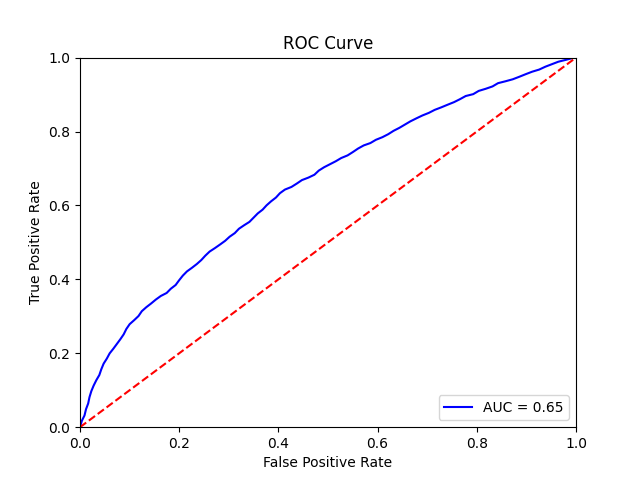

In [42]:
# Get ROC curve and send it to Pandas so that we can plot it
roc_df = evaluationSummary.roc.toPandas()

plt.plot(roc_df.FPR, roc_df.TPR, 'b', label = 'AUC = %0.2f' % evaluationSummary.areaUnderROC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

%matplot plt